In [1]:
import numpy as np
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from simulation import Simulation
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
device

'cuda'

In [4]:
# I am setting v_0=b, so we start the process in its long-term mean

alpha = 0.6
b = 0.04
sigma = 0.14
v_0 = 0.04
years = 60
gamma = 0.4

sim = Simulation(alpha, b, sigma, v_0, years, gamma = gamma, seed=True)

In [5]:
# Create a new contract every 380 days
arrival_times = np.array([i*380 for i in range(years) if i*380 < 365*years])
print('Simulation horizon: ', sim.TotPoints)
print('Arrival times: ', arrival_times)

Simulation horizon:  21900
Arrival times:  [    0   380   760  1140  1520  1900  2280  2660  3040  3420  3800  4180
  4560  4940  5320  5700  6080  6460  6840  7220  7600  7980  8360  8740
  9120  9500  9880 10260 10640 11020 11400 11780 12160 12540 12920 13300
 13680 14060 14440 14820 15200 15580 15960 16340 16720 17100 17480 17860
 18240 18620 19000 19380 19760 20140 20520 20900 21280 21660]


In [6]:
class Contract:

    def __init__(self, t_0, sim):
        # contract start time
        self.t_0 = int(t_0)
        # contract end time
        self.T = self.t_0 + 365
        self.delta = 1.
        self.sim = sim

    def get_contract_features(self, t):
        t = int(t)
        contract = torch.tensor([(self.T - t)/365.,                                      # (T-t)/365
                             np.log(self.sim.Price(self.t_0, self.T)),                   # p(t_0, T)
                             np.log(self.sim.Price(t, self.T))])#,                       # p(t, T)
                             #COMMENTED: FOCUS ON FIXED LEG
                             #np.log(self.sim.B(self.t_0)),                               # B_t_0
                             #np.log(self.sim.B(t))])#,                                   # B_t
                             #self.sim.MarkToMarketPrice(1, self.t_0, t, self.T)])       # V(t)
        return contract

    def is_active(self, t):
        t = int(t)
        if t >= self.t_0 and t <= self.T:
            return True
        else:
            return False

# Create dataset

In [7]:
# Create contracts
contracts = []
for arrival_time in arrival_times:
    contract = Contract(arrival_time, sim)
    contracts.append(contract)

# Compute maximum number of simultaneously active contracts
max_n_active_contracts = 0
for t in range(sim.TotPoints):
    n_active_contracts = np.sum([contract.is_active(t) for contract in contracts])
    if n_active_contracts > max_n_active_contracts:
        max_n_active_contracts = n_active_contracts

print(f"Max number of simultaneously active contracts: {max_n_active_contracts}")

# Create dataset (features + target)
n_contract_features = len(contracts[0].get_contract_features(0))
# features
X = torch.zeros((sim.TotPoints, max_n_active_contracts*n_contract_features)) 
# targets
y_float = torch.zeros(sim.TotPoints) 
y_fixed = torch.zeros(sim.TotPoints)

for i_time, t in enumerate(range(sim.TotPoints-1)):
    active_contracts = [contract for contract in contracts if contract.is_active(t)]
    for i_contract, contract in enumerate(active_contracts):
        
        contract_features = contract.get_contract_features(t)
        X[i_time, i_contract*len(contract_features) : (i_contract+1)*len(contract_features)] = contract_features
        
        # The targets are summed across active contracts, so we get the net value across contracts
        # (e.g. net variation margin or net value of contracts)
        
        #COMMENTED: FOCUS ON SINGLE LEGS
        #y[i_time] += sim.MarkToMarketPrice(contract.delta, contract.t_0, t, contract.T)
        
        y_float[i_time] += np.log(sim.GetFloatingLeg(contract.t_0, t) )
        y_fixed[i_time] += np.log(sim.GetFixedLeg(contract.t_0, t, contract.T))
        

Max number of simultaneously active contracts: 1


/u/mcitterio/temp/Generative-models-for-financial-networks/NodeRegression/simulation.py:183: RuntimeWarning: divide by zero encountered in divide
  return np.where(condition, 0, (tau>0)*(-1 / tau) * ((price(t_0, T) - 1) / price(t_0, T)) )
/u/mcitterio/temp/Generative-models-for-financial-networks/NodeRegression/simulation.py:183: RuntimeWarning: invalid value encountered in multiply
  return np.where(condition, 0, (tau>0)*(-1 / tau) * ((price(t_0, T) - 1) / price(t_0, T)) )


In [8]:
# Old code (written by Matteo, before Feb 15)

# def prepare_contract(arrival_time, sim, t):
#     contract = np.zeros(6)
#     contract[0] = int(arrival_time + 365 - t)/365                                 #(T-t)/365 ()   
#     contract[1] = +1 #np.random.choice ([-1,1])                                   #delta
#     contract[2] = sim.Price(int(arrival_time), int(arrival_time + 365))           #p(t_0, T)    
#     contract[3] = sim.Price(int(t), int(arrival_time + 365))                      #p(t, T)      
#     contract[4] = np.prod(1+(sim.CIRProcess[0:arrival_time+1]*1/365))             #B_t_0.       
#     contract[5] = sim.MarkToMarketPrice(+1, arrival_time, t, arrival_time + 365)  #V(t) 
#     return contract
    
# def get_arrival_time(t):
#     return (t//380)*380

# X = []
# #I need an auxiliary array that contains (t_0, T, delta) so that i can use `Simulation` methods to compute the targets M_t
# X_for_simulation = []

# for i in range(years):
    
#     for t in range((i*380), np.minimum((i*380) + 364 +1, sim.TotPoints)):
        
#         arrival_time = get_arrival_time(t)
#         contract = prepare_contract(arrival_time, sim, t)
        
#         X.append(contract)
#         X_for_simulation.append(np.array([arrival_time, arrival_time + 364, +1]))
    
#     for i in range(np.minimum((i*380) + 364, sim.TotPoints), np.minimum(((i+1) * 380) - 1, sim.TotPoints)):
        
#         X.append(np.zeros((6)))
#         X_for_simulation.append(np.zeros((3)))


# print('Len X: ', len(X))
# print('Len auxiliary X: ', len(X_for_simulation))


# #Let's put them into tensors
# X = torch.tensor(np.stack(X))
# X_for_simulation = torch.tensor(np.stack(X_for_simulation))


# #Define targets
# targets_vt = np.zeros((len(X)))   #Contains V(t) for t\in [0, sim.totPoints -1]
# #targets_vt_1 = np.zeros((len(X)-1)) #Contains V(t+1) for t\in [0, sim.totPoints]
# #targets_mt_1 = np.zeros((len(X)-1)) #Contains M(t+1) for t\in [0, sim.totPoints]


# #Fill targets
# for i in range(years):
    
#     start_index = (i * 380)
#     end_index = np.minimum((i*380) + 364 + 1, sim.TotPoints)
    
#     vt = np.asarray([sim.MarkToMarketPrice(+1, int(X_for_simulation[t,0]), t, int(X_for_simulation[t,1])) for t in range((i * 380), np.minimum((i*380) + 364 +1, sim.TotPoints))])
#     #vt1 = np.asarray([sim.MarkToMarketPrice(+1, int(X_for_simulation[t+1,0]), t+1, int(X_for_simulation[t+1,1])) for t in range((i * 380), np.minimum((i*380) + 364 +1, sim.TotPoints-1))])
#     #mt1 = np.asarray([sim.GetInstantContractMarginValue(t+1, X_for_simulation[t+1]) for t in range((i * 380), np.minimum((i*380) + 364 +1 , sim.TotPoints-1))])

#     #targets_mt_1[ start_index : end_index] = mt1
#     targets_vt[ start_index : end_index] = vt
#     #targets_vt_1[ start_index : end_index] = vt1


In [9]:
# #For scaling the targets
# def scale_target(target, training_index):
#     """
#     Scales and reshape the tensor so that it has shape [sim.totPoints -1 , 1]
#     """

#     target = target.clone().detach().reshape(-1,1)
    
#     scaler = MinMaxScaler()
#     scaler.fit(target[:training_index].cpu())
#     scaler.scale_ /= 1.25

#     target = scaler.transform(target.cpu())
#     return torch.tensor(target).to(torch.float32).to(device)

In [10]:
# Train-test split

training_index = int(0.8 * X.shape[0])

CIRProcess = torch.tensor(sim.CIRProcess.reshape(-1,1)).to(torch.float32).to(device)

#Prepare both legs
y_float_train = y_float[:training_index]
y_fixed_train = y_fixed[:training_index]
X_train = X[:training_index, :]
CIR_train = CIRProcess[:training_index]

y_float_test = y_float[training_index:]
y_fixed_test = y_fixed[training_index:]
X_test = X[training_index:, :]
CIR_test = CIRProcess[training_index:]

In [11]:
def create_windows(features, targets_float, targets_fixed, r, lookback):
    """
    Windows the dataset
    """
    n_samples = features.shape[0] - lookback

    X_data = torch.zeros(n_samples, lookback, features.shape[1])
    y_float_data = torch.zeros(n_samples, 1)
    y_fixed_data = torch.zeros(n_samples, 1)
    r_data = torch.zeros(n_samples, 1)

    for i_sample in range(n_samples):

        X_data[i_sample, :] = features[i_sample : i_sample + lookback]   #it takes data in [i_sample, i_sample+lookback)
        y_float_data[i_sample, 0] = targets_float[i_sample + lookback]   #it takes [i_sample + lookback] which is +1 time shifted w.r.t. the feature set
        y_fixed_data[i_sample, 0] = targets_fixed[i_sample + lookback]
        r_data[i_sample, 0] = r[i_sample + lookback]
        
    return X_data.to(torch.float32).to(device), y_float_data.to(torch.float32).to(device), y_fixed_data.to(torch.float32).to(device), r_data.to(torch.float32).to(device)
    

In [12]:
# Slice dataset into windows

lookback = 10
X_train, y_float_train, y_fixed_train, r_train = create_windows(X_train, y_float_train, y_fixed_train, CIR_train, lookback=lookback)
X_test, y_float_test, y_fixed_test, r_test = create_windows(X_test, y_float_test, y_fixed_test, CIR_test, lookback=lookback)


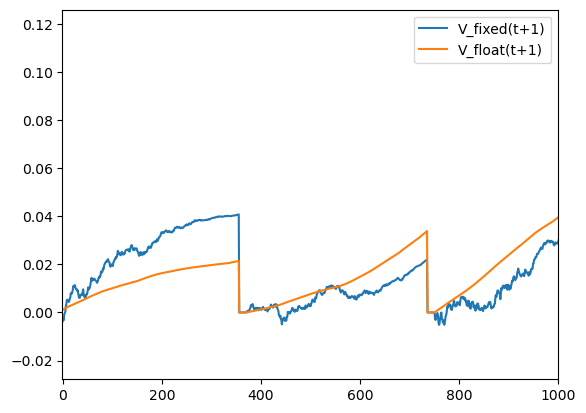

In [13]:
plt.plot(y_fixed_train.cpu(), label='V_fixed(t+1)')
plt.plot(y_float_train.cpu(), label='V_float(t+1)')
plt.xlim(-1,1000)
plt.legend()
plt.show()

In [14]:
#Build the pytorch datasets and dataloaders
train_dataset = TensorDataset(X_train.to(device), y_float_train.to(device), y_fixed_train.to(device), r_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_float_test.to(device), y_fixed_test.to(device), r_test.to(device))

loader = DataLoader(train_dataset, shuffle=True, batch_size=1000)
loader_test = DataLoader(test_dataset, shuffle=True, batch_size = 1000)

In [15]:
#define the model
class model(nn.Module):

    def __init__(self):
        super(model, self).__init__()

        input_size = 3
        lstm_hidden_size = 5
        lstm_n_layers = 1
        regressor_hidden_size = 256
        self.name=regressor_hidden_size

        self.lstm = torch.nn.LSTM(input_size=input_size, 
                             hidden_size=lstm_hidden_size, 
                             num_layers=lstm_n_layers)
        
        #Il +1 è perchè facciamo il concat con il reference interest rate
        self.regressor = nn.Sequential(nn.Linear(lstm_hidden_size+1, regressor_hidden_size),
                                       nn.ReLU(),
                                       nn.Linear(regressor_hidden_size, regressor_hidden_size),
                                       nn.ReLU(),
                                       nn.Linear(regressor_hidden_size, 1))
        
        self.reset_parameters()

    def forward(self, x, r):

        lstm_hidden, _ = self.lstm(x)
        return self.regressor(torch.squeeze(torch.cat([lstm_hidden[:,-1,:], 1.+r/365.],dim=1)))
    
    def reset_parameters(self):

        self.lstm.reset_parameters()
        for layer in [self.regressor]:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

In [16]:
#Let's get towards the training:

lr = 5e-2                         #Learning rate
criterion = nn.MSELoss()           #Loss function

#Define the model
mymodel = model().to(device)    

#optimizer & scheduler
optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100*i for i in range(100)], gamma=0.9)

n_epochs = 10000                   #Number of epochs

#Early stopping parameters
patience = 30                      #Number of consecutive epochs to wait for improvement

In [17]:
#print the model
mymodel

model(
  (lstm): LSTM(3, 5)
  (regressor): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [18]:
def do_epoch(loader, model, criterion, optimizer, training=True):
    """
    Trains the model over the batches for an epoch
    """
    
    #Instantiate a temp variable that tracks the average loss for the batches
    temp_loss = 0

    #Loop over data batches
    for X_batch, y_float_batch, y_fixed_batch, r_batch in loader:

        #.forward() method of the model, will output both V_float and V_fixed
        y_pred = model(X_batch, r_batch)
        #y_float_pred = y_pred
        y_fixed_pred = y_pred
        
        #y_float_pred, y_fixed_pred = y_pred[:,0], y_pred[:,1]

        #Compute the loss - FOCUS ON FIXED LEG
        loss = criterion(y_fixed_pred.squeeze(), y_fixed_batch.squeeze()) #+ criterion(y_fixed_pred, y_fixed_batch.squeeze())

        #If we are actually training the model instead of permorming validation
        if training:

            #Backpropagation
            loss.backward()
    
            #Optimizer step
            optimizer.step() 
            optimizer.zero_grad()

        #Track the batch loss
        temp_loss += loss.item()

    #Take the average loss over the batches
    return temp_loss / len(loader)

In [19]:
#Early stopping class
class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_score = 10
        self.early_stop = False

    def __call__(self, val_loss, model):
    
        if val_loss > self.best_score:

            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:

            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), f'temp_state_dict{mymodel.name}.pt')

In [20]:
#Define two lists to store training record
training_loss = []
validation_loss = []
lrs = []

#Define a tqdm loop to get a nice progress bar
loop = tqdm(range(n_epochs))

#Define an early stopping object
early_stopping = EarlyStopping(patience)

for epoch in loop:

    #Set model in training mode
    mymodel.train()

    #Perform an epoch of training
    train_loss = do_epoch(loader, mymodel, criterion, optimizer)

    #Scheduler step
    scheduler.step()

    #Track the average over the batches
    training_loss.append(train_loss)

    
    #Validation every 50 epochs
    if epoch % 50 ==0:

        with torch.no_grad():
            #Set the model in eval mod
            mymodel.eval()

            test_loss = do_epoch(loader_test, mymodel, criterion, optimizer, training=False)

            #Track the average loss over the batches
            validation_loss.append(test_loss)

        #Check early stopping
        early_stopping(validation_loss[-1], mymodel)
        if early_stopping.early_stop:

            #Load the best set of parameters
            mymodel.load_state_dict(torch.load(f'temp_state_dict{mymodel.name}.pt'))
            print(f"Early stopping at epoch {epoch}.")
            break

    lrs.append(optimizer.param_groups[0]["lr"])
            
    #Give informations in the loop
    loop.set_postfix(loss = train_loss, val_loss = test_loss, best_val_loss = early_stopping.best_score, counter=early_stopping.counter, lr= lrs[-1])


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#Plot training record & learning rate schedule

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(training_loss, label='Train')
val_epochs= np.linspace(0, len(training_loss), num=len(validation_loss))
plt.plot(val_epochs, validation_loss, label='Val')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('log(MSE)')
plt.title('Training ')

plt.subplot(1,2,2)
plt.plot(lrs)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.title('Learning rate')

plt.tight_layout()
plt.show()

In [ ]:
#Makes the predictions
def predictions(dataset, model):

    dataloader = DataLoader(dataset, shuffle=False, batch_size=1)

    y_float_preds = torch.zeros(len(dataloader))
    y_fixed_preds = torch.zeros(len(dataloader))
    
    y_fixed_trues = torch.zeros(len(dataloader))
    y_float_trues = torch.zeros(len(dataloader))
    
    for i_sample, (X, y_float, y_fixed, r) in enumerate(dataloader):
        with torch.no_grad():
            
            y_preds = model(X,r).cpu()
            # FOCUS ON FIXED LEG
            y_fixed_preds[i_sample] = y_preds#, y_fixed_preds[i_sample] = y_preds[0], y_preds[1]
            y_float_trues[i_sample], y_fixed_trues[i_sample] = y_float.cpu(), y_fixed.cpu()
            
    return y_float_trues.numpy(), y_fixed_trues.numpy(), y_float_preds.numpy(), y_fixed_preds.numpy()

In [ ]:
#Get the predictions
train_float_labels, train_fixed_labels, train_float_predictions, train_fixed_predictions = predictions(train_dataset, mymodel)
test_float_labels, test_fixed_labels, test_float_predictions, test_fixed_predictions =predictions(test_dataset, mymodel)

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(train_float_labels, 'r-', label='$V(t+1)$ label')
plt.plot(train_float_predictions, 'b-', label='Prediction')
#plt.xlim(10,20)
plt.grid()
plt.legend()
plt.title('Non-shifted float train')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(train_fixed_labels, 'r-', label='$V(t+1)$ label')
plt.plot(train_fixed_predictions, 'b-', label='Prediction')
plt.xlim(0,400)
plt.grid()
plt.legend()
plt.title('Non-shifted fixed train')

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(test_float_labels, 'r-', label='$V(t+1)$ label')
plt.plot(test_float_predictions, 'b-', label='Prediction')
plt.xlim(1000,1200)
plt.grid()
plt.legend()
plt.title('Non-shifted float test')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot((test_fixed_labels), 'r-', label='$V(t+1)$ label')
plt.plot((test_fixed_predictions), 'b-', label='Prediction')
plt.xlim(160,300)
plt.grid()
plt.legend()
plt.title('Non-shifted fixed test')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(test_fixed_labels[:-1], 'r-', label='$V(t+1)$ label')
plt.plot(test_fixed_predictions[1:], 'b-', label='Prediction')
plt.xlim(160,300)
plt.grid()
plt.legend()
plt.title('shifted fixed test')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (test)
plt.figure(figsize=(6,3), dpi=300)

plt.subplot(1,2,1)
plt.plot(test_float_labels, 'r.', label='$V(t+1)$ label')
plt.plot(test_float_predictions, 'bx', label='Prediction')
#plt.xlim(100,150)
plt.grid()
plt.legend()
plt.title('Non-shifted')

plt.subplot(1,2,2)
plt.plot(test_labels[:-1], 'r.', label='$V(t+1)$ label')
plt.plot(test_predictions[1:], 'bx', label='Prediction')
#plt.xlim(100,150)
plt.grid()
plt.legend()
plt.title('Shifted')

plt.tight_layout()
plt.show()

If I try to compute the loss between targets and labels i find, as expected, the same best val loss I observed during training:

However, If i shift the arrays I find a better loss

In [ ]:
criterion(torch.tensor(test_fixed_labels), torch.tensor(test_fixed_predictions))

In [ ]:
criterion(torch.tensor(test_fixed_labels[:-1]), torch.tensor(test_fixed_predictions[1:]))